<a href="https://colab.research.google.com/github/tsuyuwou/LeNet-based-image-classifier/blob/main/LeNet_based_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to project write-up: [LeNet-based Image Classifier](https://docs.google.com/document/d/1C0T8-c9rgpevc-J4H2HLR22bJz1KJkQ5/edit?usp=sharing&ouid=104925127473427161382&rtpof=true&sd=true)

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numba import njit

In [ ]:
# Load dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [ ]:
# Normalize pixel values to be between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
# Add uniform noise
def uniform_noise(snr, images):
  for i in range(len(images)):
    img = images[i]
    ps = np.sum(np.square(img))
    pw = ps / snr
    noise = np.sqrt(pw / np.size(img))
    noisy_img = np.where(img + noise > 1, img - noise, img + noise)
    images[i] = noisy_img
  return images

# Add centered horizontal strip of noise
@njit
def concentrated_noise(snr, images):
  for i in range(len(images)):
    img = images[i]
    ps = np.sum(np.square(img))
    pw = ps / snr
    for j in range(16, 32):
      for k in range(32):
        for l in range(3):
          val = images[i][j][k][l]
          if val >= 0.5:
            if val > pw ** 0.5:
              images[i][j][k][l] = val - pw ** 0.5
              pw = 0
              j = k = 31
              l = 2
            else:
              images[i][j][k][l] = 0
              pw -= val ** 2
          else:
            if 1 - val > pw ** 0.5:
              images[i][j][k][l] = val + pw ** 0.5
              pw = 0
              j = k = 31
              l = 2
            else:
              images[i][j][k][l] = 1
              pw -= (1 - val) ** 2
  return images

# Removes a centered horizontal strip of pixels
@njit
def remove_pixels(snr, images):
  for i in range(len(images)):
    img = images[i]
    ps = np.sum(np.square(img))
    pw = ps / snr
    for j in range(16, 32):
      for k in range(32):
        for l in range(3):
          val = images[i][j][k][l]
          if val > pw ** 0.5:
            images[i][j][k][l] = val - pw ** 0.5
            pw = 0
            j = k = 31
            l = 2
          else:
            images[i][j][k][l] = 0
            pw -= val ** 2
  return images

# Add random noise
@njit
def random_noise(snr, images):
  for i in range(len(images)):
    img = images[i]
    ps = np.sum(np.square(img))
    pw = ps / snr
    idx = np.random.choice(int(img.size / 3), int(0.8 * img.size / 3) + 1)
    for j in range(len(idx)):
      col = int(idx[j] / np.shape(img)[0])
      row = int(idx[j] % np.shape(img)[0])
      for k in range(3):
        val = images[i][row][col][k]
        if val > pw ** 0.5:
          images[i][row][col][k] = val - pw ** 0.5
          pw = 0
          j = len(idx) - 1
          k = 2
        else:
          images[i][row][col][k] = 0
          pw -= val ** 2
  return images

# Apply noise to images
def apply_noise(noise_type, snr, images):
  if noise_type == 0:
    return uniform_noise(snr, images)
  elif noise_type == 1:
    return concentrated_noise(snr, images)
  elif noise_type == 2:
    return remove_pixels(snr, images)
  elif noise_type == 3:
    return random_noise(snr, images)

In [ ]:
# Signal-to-noise ratio is kept constant for all images
snr = 10

In [ ]:
# Add noise to images
noisy_train_images = apply_noise(3, snr, train_images.copy())
noisy_test_images = apply_noise(3, snr, test_images.copy())

In [ ]:
# Convolutional autoencoder architecture
autoencoder = tf.keras.Sequential()
autoencoder.add(layers.Input(shape=(32, 32, 3)))
autoencoder.add(layers.UpSampling2D(size=(2,2)))
autoencoder.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
autoencoder.add(layers.BatchNormalization())
autoencoder.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
autoencoder.add(layers.BatchNormalization())
autoencoder.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
autoencoder.add(layers.BatchNormalization())
autoencoder.add(layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2))
autoencoder.add(layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2))
autoencoder.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
autoencoder.summary()

# Train the autoencoder
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=4000, decay_rate=0.8)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule), loss=tf.keras.losses.MeanSquaredError())
training = autoencoder.fit(noisy_train_images, train_images, epochs=10, shuffle=False, validation_data=(noisy_test_images, test_images))
denoised_images = autoencoder(noisy_test_images).numpy()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 64, 64, 3)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        4624      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 16)       64        
 hNormalization)                                                 
                                                        

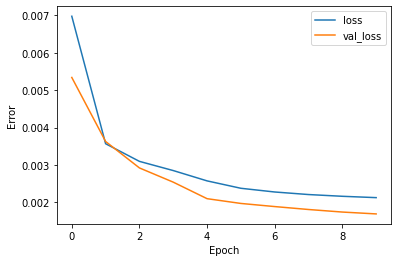

In [ ]:
# Plot loss
plt.plot(training.history['loss'], label='loss')
plt.plot(training.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(loc='upper right')

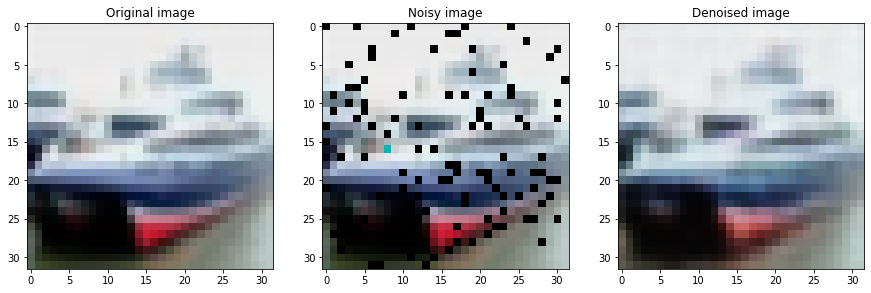

In [ ]:
# Original, noisy, and denoised images using autoencoder
_, axarr = plt.subplots(1, 3, figsize=(15, 15))
index = 1
axarr[0].set_title("Original image")
axarr[0].imshow(test_images[index])
axarr[1].set_title("Noisy image")
axarr[1].imshow(noisy_test_images[index])
axarr[2].set_title("Denoised image")
axarr[2].imshow(denoised_images[index])

In [ ]:
# Architecture (based on LeNet)
model = tf.keras.models.Sequential()
model.add(layers.InputLayer(input_shape=(32,32,3)))
model.add(layers.UpSampling2D(size=(2,2)))
model.add(layers.RandomZoom(0.4, 0.6))
model.add(layers.Conv2D(32, 3, padding="same", strides=1, activation="relu", use_bias=True))
model.add(layers.Conv2D(64, 3, padding="same", strides=1, activation="relu", use_bias=True))
model.add(layers.MaxPool2D(pool_size=(2,2), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, 3, padding="same", strides=1, activation="relu", use_bias=True))
model.add(layers.Conv2D(64, 3, padding="same", strides=1, activation="relu", use_bias=True))
model.add(layers.MaxPool2D(pool_size=(2,2), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, 3, padding="same", strides=1, activation="relu", use_bias=True))
model.add(layers.Conv2D(128, 3, padding="same", strides=1, activation="relu", use_bias=True))
model.add(layers.MaxPool2D(pool_size=(2,2), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, 3, padding="same", strides=1, activation="relu", use_bias=True))
model.add(layers.Conv2D(256, 3, padding="same", strides=1, activation="relu", use_bias=True))
model.add(layers.MaxPool2D(pool_size=(2,2), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, 3, padding="same", strides=1, activation="relu", use_bias=True))
model.add(layers.Conv2D(512, 3, padding="same", strides=1, activation="relu", use_bias=True))
model.add(layers.MaxPool2D(pool_size=(2,2), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_1 (UpSampling  (None, 64, 64, 3)        0         
 2D)                                                             
                                                                 
 random_zoom (RandomZoom)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 64)      

In [ ]:
test_images = noisy_test_images

In [ ]:
test_images = denoised_images

In [ ]:
# Exponentially decaying learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=4000, decay_rate=0.7)

# Comiled using the Adam optimizer and sparse categorical accuracy metric
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Stops early if validation loss increased in the 2 most recent epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Batch size is set to 25 images and the maximum number of epochs is 20
training = model.fit(x=train_images, y=train_labels, validation_data=(test_images, test_labels), epochs=20, callbacks=[callback], batch_size=25)

Epoch 1/20
2000/2000 [==============================] - 47s 23ms/step - loss: 1.6474 - sparse_categorical_accuracy: 0.4025 - val_loss: 1.8849 - val_sparse_categorical_accuracy: 0.3720
Epoch 2/20
2000/2000 [==============================] - 44s 22ms/step - loss: 1.1724 - sparse_categorical_accuracy: 0.5823 - val_loss: 1.7468 - val_sparse_categorical_accuracy: 0.4196
Epoch 3/20
2000/2000 [==============================] - 44s 22ms/step - loss: 0.9136 - sparse_categorical_accuracy: 0.6803 - val_loss: 3.8855 - val_sparse_categorical_accuracy: 0.2201
Epoch 4/20
2000/2000 [==============================] - 44s 22ms/step - loss: 0.7639 - sparse_categorical_accuracy: 0.7348 - val_loss: 2.3272 - val_sparse_categorical_accuracy: 0.3559


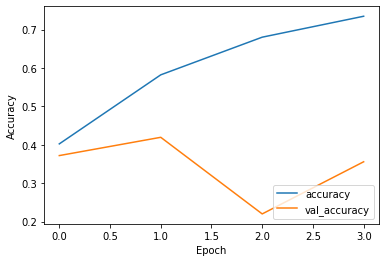

In [ ]:
# Plot accuracy
plt.plot(training.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(training.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

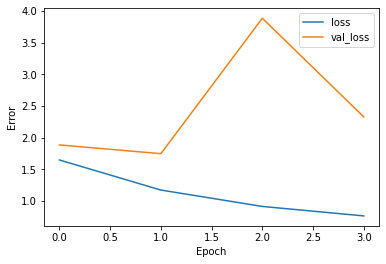

In [ ]:
# Plot loss
plt.plot(training.history['loss'], label='loss')
plt.plot(training.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(loc='upper right')

In [ ]:
# Predictions
predictions = model.predict(test_images)
decoded_predictions = np.array([np.argmax(prediction) for prediction in predictions])
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

313/313 [==============================] - 3s 8ms/step


[Text(0, 0.5, 'airplane'),
 Text(0, 1.5, 'automobile'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'ship'),
 Text(0, 9.5, 'truck')]

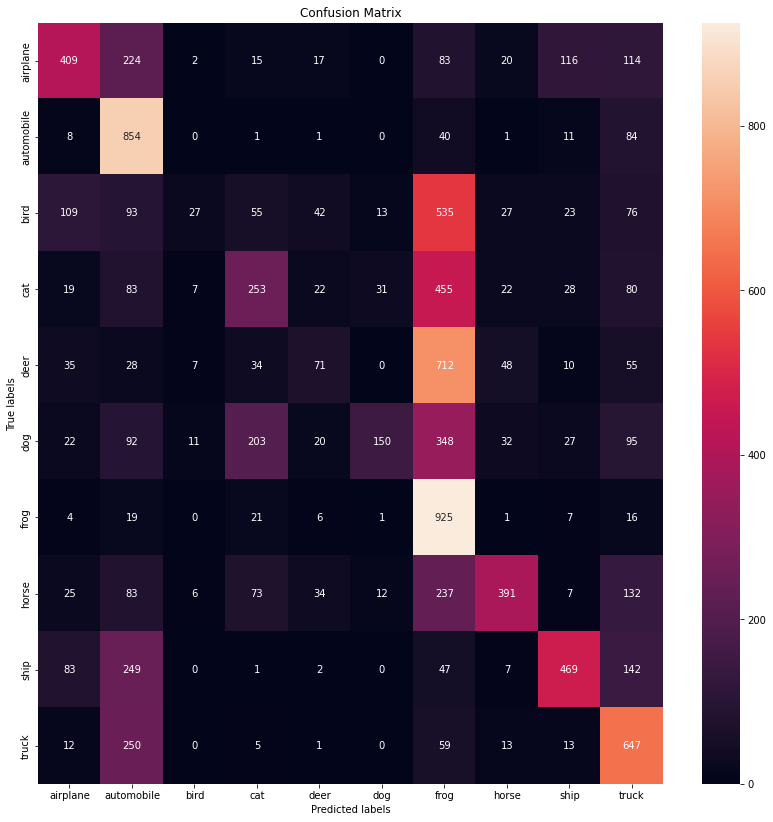

In [ ]:
# Plot confusion matrix
confusion_matrix = tf.math.confusion_matrix(test_labels, decoded_predictions)
plt.figure(figsize=(14,14))
ax = plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
# Recall
class_num = 0
print("Recall For Each Class\n")
for c in confusion_matrix:
  print(f"{labels[class_num]}: {(c[class_num].numpy()/sum(c)).numpy()}")
  class_num += 1

Recall For Each Class

airplane: 0.344
automobile: 0.636
bird: 0.065
cat: 0.275
deer: 0.192
dog: 0.385
frog: 0.917
horse: 0.692
ship: 0.373
truck: 0.52


In [ ]:
# Precision
print("Precision For Each Class\n")
for class_num in range(len(confusion_matrix)):
  print(f"{labels[class_num]}: {confusion_matrix[:,class_num][class_num].numpy()/sum(confusion_matrix[:,class_num]).numpy():.4f}")

Precision For Each Class

airplane: 0.5972
automobile: 0.6431
bird: 0.6771
cat: 0.3345
deer: 0.5260
dog: 0.4492
frog: 0.3162
horse: 0.3294
ship: 0.6442
truck: 0.7273
